# Using IBM Cloud SQL Query

<div class="pull-left"><left><img style="float: right;" src="https://cache.globalcatalog.cloud.ibm.com/api/v1/a0814030-c9dd-11e7-9a5e-19d80fed5e00/artifacts/cache/f9427c42cce19cea6d9e83128a58298f-public/Icon_32.svg" width="100" margin=50></left></div>
<div style="text-align:center">
IBM Cloud SQL Query is IBM's serverless SQL service on data on Cloud Object Storage (COS). It allows to run ANSI SQL on Parquet, CSV, JSON, ORC and AVRO data sets. You can use it to run your analytic queries, and you can use it to conduct complex transformations and write the result in any desired data format, partitioning and layout. SQL Query is based on Apache Spark SQL as the query engine in the background. This means you do not have to provision any Apache Spark instance or service. For more background information, check out the SQL Query <a href="https://console.bluemix.net/docs/services/sql-query/getting-started.html#getting-started-tutorial" target="_blank">documentation</a>.
As mentioned in that documentation, you can make a direct SQL query using the SQL Query Web UI or using a simple Python client (like the IBM Watson Studio Notebook) is sufficient.
<br><br></div>
<div>
This notebook is meant to be a generic starter to use the SQL Query API in order to run SQL statements in a programmatic way. It uses the <a href="https://github.com/IBM-Cloud/sql-query-clients/tree/master/Python" target="_blank">ibmcloudsql</a> Python library for this purpose. In the first section it is demonstrated how to setup the appropriate libraries, how to edit respectively generate SQL statements using the so-called sql-magic module, how to execute the SQL statements and finally how to work with the resulte. 
The later sections deal  with topcis for the more advanced user. 
For information about using ibmcloudsql Python library, check out the <a href="https://ibm-cloud.github.io/sql-query-clients/intro.html#ibmcloudsql" target="_blank">documentation</a>. 
As mentioned above it does not require a Spark service bound to the notebook.
    </div>

The notebook runs on Python.

<a id="toc"></a>
## Table of contents
1. [Setup libraries](#setup)<br>
2. [Configure the SQL Query client](#configure)<br>
    2.1 [Using the project bucket](#projectbucket)<br>
    2.2 [Setting SQL Query parameters](#parameters)<br>
3. [Understand the schema of your data](#schema)<br>
4. [Create your SQL statement](#sql)<br>
5. [Run your SQL statement](#run)<br>
    5.1 [Synchronous Execution](#synchronous)<br>
    5.2 [Asynchronous Execution](#lowlevel)<br>
    5.3 [Synchronous execution with optional result dataframe](#execute_sql)<br>
    5.4 [Use Paginated SQL](#paginated)<br>
    5.5 [get_job](#get_job)<br>
6.  [Running ETL SQLs](#etl)<br>
    6.1 [Using analyze() for partitioning recommendation](#analyze)
7. [Work with result objects](#results)<br>
    7.1 [list_results](#list_results)<br>
    7.2 [delete_result](#delete_result)<br>
    7.3 [Enforce exact target object name](#rename_result_objects)<br>      
8. [Work with hive tables](#catalog)<br>
9. [Manage SQL jobs](#manage_jobs)<br>
    9.1 [Work with Job History](#joblist)<br>
    9.2 [Batch automation of SQL jobs](#many_queries)<br>
10. [Next steps](#next)<br>

# <a id="setup"></a> 1. Setup libraries
[Home](#toc)

Run the following sequence of cells at least once in your notebook environment in order to install required packages: 
    - pyarrow - provides rich, powerful features for working with columnar data
    - sqlparse - a non-validating SQL parser 
    - ibmcloudsql - SQL Query client library 

In [1]:
!pip install pyarrow 
!pip install sqlparse

     |████████████████████████████████| 17.3 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.5 MB/s  eta 0:00:01


In [2]:
!pip install --upgrade --user  ibmcloudsql

     |████████████████████████████████| 41 kB 584 kB/s  eta 0:00:01
     |████████████████████████████████| 59.2 MB 385 kB/s  eta 0:00:01
  Created wheel for ibmcloudsql: filename=ibmcloudsql-0.4.9-py3-none-any.whl size=43151 sha256=9c9f08d2b3e3d08e31c0da7184b8c5b4244fde527f15a6be26168d9ff742d3ba
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/bc/68/60/f85a03ae972021be52ac473421a5edc4f3fc039580cf2c11bd
Successfully built ibmcloudsql
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Import (load) the following packages:

    - ibmcloudsql - IBM Cloud SQL Query python client
    - sqlparse - a non-validating SQL parser 
    - pandas - an open source data manipulation and analysis tool 
    - pixidust - a python display library 
    - pygments - a syntax highlighter library used to pretty print the SQL statements
    

Installing pixiedust to show case data visualization of SQL results below. Note that pixiedust support in Watson Studio Notebooks has been deprecated. In your own notebooks you can of course alternatively use any other visualization library of your choice, be it matplotlib, plotly or seaborn.

In [3]:
!pip install pixiedust

In [4]:
import ibmcloudsql
import sqlparse 
import pandas as pd
import getpass
import pprint
from pixiedust.display import *
from pygments import highlight
from pygments.lexers import get_lexer_by_name
from pygments.formatters import HtmlFormatter, Terminal256Formatter
lexer = get_lexer_by_name("sql", stripall=True)
formatter = Terminal256Formatter(style='vim')
apikey=''
instancecrn=''
targeturl=''

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully


# <a id="configure"></a> 2. Configure the SQL Query client
[Home](#toc)

1. You need an **API key** for an IBM cloud identity. This single key provides you accesses to both your Cloud Object Storage (COS) bucket for writing SQL results and to your SQL Query instance. To create API keys log on to the IBM Cloud console and go to <a href="https://console.bluemix.net/iam/#/apikeys" target="_blank">Manage->Access (IAM): then select API Keys</a>, click the `Create an IBM Cloud API key` button, give the key a custom name and click `Create`. In the next dialog click `Show` and copy the key to your clipboard and paste it below in this notebook.

2. You need the **instance CRN** for the SQL Query instance. If you don't have an SQL Query instance created yet, <a href="https://console.bluemix.net/catalog/services/sql-query" target="_blank">create one</a> first. If you already have one, you can find it in the <a href="https://console.bluemix.net/dashboard/apps" target="_blank">IBM Cloud console dashboard</a>. Make sure you select the right `Resource Groups` for **Group**. In the section `Services` you can see different types of services (created for the selected Group), and SQL service instances have the icon like the one at the top of this notebook. Select the instance of SQL Query that you want to use. In the SQL Query dashboard page that opens up you find a section titled **Overview** with *Deployment Details* and copy the text after **CRN**. Click the button to copy the CRN into your clipboard and paste it here into the notebook. 

3. You need to specify the location on COS where your **query results** should be written.This is because SQL Query instance, to process an ETL SQL statement, needs to store queried data on COS.
This COS location comprises three parts of information that you can find in the Cloud Object Storage UI for your instance in the IBM Cloud console. You need to provide it as a **target_cos_url** using the format `cos://<endpoint>/<bucket>/[<prefix>]`. 

In case you want to use the **cloud object storage bucket that is associated with your Watson Studio project** as target location for your query results you can make use of the project token for access and construct the target_cos_url as follows:  
<br/>

## <a id="projectbucket"></a> 2.1 Using the project bucket
**Only** follow the instructions in this section when you want to write your SQL query results to the bucket that has been created for the project for which you have created this notebook. In any other case proceed directly with section **2.2**.
<br><br>
__Inserting the project token__:  
Click the `More` option in the toolbar above (the three stacked dots) and select `Insert project token`.
 * If you haven't created an access token for this project before, you will see a dialog that asks you to create one first. Follow the link to open your project settings, scroll down to `Access tokens` and click `New token`. Give the token a custom name and make sure you select `Editor` as `Access role for project`. After you created your access token you can come back to this notebook, select the empty cell below and again select `Insert project token` from the toolbar at the top.
[//]: # 
This will add a new cell at the top of your notebook with content that looks like this:
```
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='<some id>', project_access_token='<some access token>')
pc = project.project_context
```
Leave that cell content as inserted and run the cell. Then then proceed with the following cell below:

In [ ]:
cos_bucket = project.get_metadata()['entity']['storage']['properties']
targeturl="cos://" + cos_bucket['bucket_region'] + "/" + cos_bucket['bucket_name'] + "/"
targeturl

## <a id="parameters"></a> 2.2 Setting the SQL Query parameters
Now let's instantiate and configure an SQLQuery Client. During instantiation the client accesses the SQL Query instance you selected and returns the link to the SQL Query service instance web console. You can use this link later to author an SQL statement interactively. 

In addition to the parameters entered interactively here, there is two more optional parameters **max_concurrent_jobs** (from version 0.4) and  **max_tries**  
    For details see  <a href="https://ibm-cloud.github.io/sql-query-clients/ibmcloudsql.html#ibmcloudsql.SQLQuery.SQLQuery">use</a>. 

In [6]:
if apikey == '':
    apikey=getpass.getpass('Enter IBM Cloud API Key: ')
else:
    apikey=getpass.getpass('Enter a new IBM Cloud API Key or leave empty to use the previous one: ') or apikey
if instancecrn == '':
    instancecrn=input('Enter SQL Query instance CRN totorsten@de.ibm.comtorsten@de.ibm.com use: ')
else:
    instancecrn=input('Enter new SQL Query instance CRN to use (leave empty to use ' + instancecrn + '): ') or instancecrn
if targeturl == '':
    targeturl=input('Enter target URL for SQL results: ')
else:
    targeturl=input('Enter new target URL for SQL results (leave empty to use ' + targeturl + '): ') or targeturl
 
 
sqlClient = ibmcloudsql.SQLQuery(apikey, instancecrn, client_info='SQL Query Starter Notebook', target_cos_url=targeturl, max_concurrent_jobs=4, max_tries=3 )
#sqlClient.configure()  # use this if you want to change the API key or SQL Query CRN later

sqlClient.logon()

Enter IBM Cloud API Key: ········
Enter SQL Query instance CRN totorsten@de.ibm.comtorsten@de.ibm.com use: crn:v1:bluemix:public:sql-query:us-south:a/d86af7367f70fba4f306d3c19c938f2f:d1b2c005-e3d8-48c0-9247-e9726a7ed510::
Enter target URL for SQL results: cos://us-south/sqltempregional/


In [7]:
print('\nYour SQL Query web console link:\n')
sqlClient.sql_ui_link()


Your SQL Query web console link:

https://sql-query.cloud.ibm.com/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/d86af7367f70fba4f306d3c19c938f2f:d1b2c005-e3d8-48c0-9247-e9726a7ed510::


'https://sql-query.cloud.ibm.com/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/d86af7367f70fba4f306d3c19c938f2f:d1b2c005-e3d8-48c0-9247-e9726a7ed510::'

# <a id="schema"></a> 3. Get the schema of your data
[Home](#toc)

In order to work with your data using SQL Query you need to know the schema of your data. Since `ibmcloudsql` version 0.4, you can directly query the <a href="https://ibm-cloud.github.io/sql-query-clients/ibmcloudsql.html#ibmcloudsql.SQLQuery.SQLQuery.get_schema_data">schema of the data</a>. Let's have a look at the employees.parquet dataset provided with SQL Query as a sample dataset. Note, that the first invocation uses the parameter `dry_run=True` which is done here to demonstrate you can get a preview of the statement being executed.

**NOTE**: If you want to work with [hive table](#catalog), there is another API: `describe_table()` that returns the schema of your defined table. 

In [8]:
sqlClient.get_schema_data("cos://us-geo/sql/employees.parquet", type="parquet", dry_run=True)

sqlClient.get_schema_data("cos://us-geo/sql/employees.parquet", type="parquet")


        SELECT * FROM DESCRIBE(cos://us-geo/sql/employees.parquet STORED AS PARQUET)
        INTO cos://us-south/sqltempregional/ STORED AS JSON
        


,name,nullable,type
0,employeeID,True,integer
1,lastName,True,string
2,firstName,True,string
3,title,True,string
4,titleOfCourtesy,True,string
5,birthDate,True,timestamp
6,hireDate,True,timestamp
7,address,True,string
8,city,True,string
9,region,True,string


# <a id="sql"></a> 4. Create your SQL statement 
[Home](#toc)

Now that we know the schema of our data sets we can create an SQL statement to be executed on these data. You provide the SQL statement in the form of a **string**. In the subsequent cell a sample SQL statement on the above listed example datasets provided with SQL Query is given. You can either use that sample statement for the subsequent steps or copy and paste your own statement, which you may have authored using the SQL Query Web Console (**link above**) of your SQL Query service instance.

In [9]:
sql=input('Enter your SQL statement (leave empty to use a simple sample SQL)')

if sql == '':
    sql='SELECT o.OrderID, c.CompanyName, e.FirstName, e.LastName FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o, \
         cos://us-geo/sql/employees.parquet STORED AS PARQUET e, cos://us-geo/sql/customers.parquet STORED AS PARQUET c \
         WHERE e.EmployeeID = o.EmployeeID AND c.CustomerID = o.CustomerID AND o.ShippedDate > o.RequiredDate AND o.OrderDate > "1998-01-01" \
         ORDER BY c.CompanyName'
if " INTO " not in sql:
    sql += ' INTO {}myQueryResult STORED AS CSV'.format(targeturl)
formatted_sql = sqlparse.format(sql, reindent=True, indent_tabs=True, keyword_case='upper')
lexer = get_lexer_by_name("sql", stripall=True)
formatter = Terminal256Formatter(style='tango')
result = highlight(formatted_sql, lexer, formatter)
from IPython.core.display import display, HTML
print('\nYour SQL statement is:\n')
print(result)

Enter your SQL statement (leave empty to use a simple sample SQL)

Your SQL statement is:

SELECT o.OrderID,
	c.CompanyName,
	e.FirstName,
	e.LastName
FROM cos://us-geo/SQL/orders.parquet STORED AS PARQUET o,
	cos://us-geo/SQL/employees.parquet STORED AS PARQUET e,
	cos://us-geo/SQL/customers.parquet STORED AS PARQUET c
WHERE e.EmployeeID = o.EmployeeID
		AND c.CustomerID = o.CustomerID
		AND o.ShippedDate > o.RequiredDate
		AND o.OrderDate > "1998-01-01"
ORDER BY c.CompanyName INTO cos://us-south/sqltempregional/myQueryResult STORED AS CSV



Since version 0.4, *ibmcloudsql* provides a new alternartive way to construct your SQL statement, using the functionality called <a href="https://github.com/IBM-Cloud/sql-query-clients/blob/master/Python/ibmcloudsql/sql_magic.py">*sql_magic*</a>. The documentation is available <a href="https://ibm-cloud.github.io/sql-query-clients/sql_magic.html#sqlmagic">here</a>. The same example SQL statement as above, can be generated with the sql_magic api as demonstrated in the following code.

In [10]:
sqlClient.reset_()
(sqlClient.select_("o.OrderID, c.CompanyName, e.FirstName, e.LastName")
        .from_cos_("cos://us-geo/sql/orders.parquet", format_type="parquet", alias="o")
        .from_cos_("cos://us-geo/sql/employees.parquet", format_type="parquet", alias="e")
        .from_cos_("cos://us-geo/sql/customers.parquet", alias="c")
        .where_('e.EmployeeID = o.EmployeeID AND c.CustomerID = o.CustomerID AND o.ShippedDate > o.RequiredDate AND o.OrderDate > "1998-01-01"')
        .order_by_("c.CompanyName")
        .store_at_(targeturl + "myResult", format_type="csv")
)

sqlClient.print_sql()

SELECT o.OrderID,
       c.CompanyName,
       e.FirstName,
       e.LastName
FROM cos://us-geo/sql/orders.parquet STORED AS parquet o, cos://us-geo/sql/employees.parquet STORED AS parquet e, cos://us-geo/sql/customers.parquet STORED AS parquet c
WHERE e.EmployeeID = o.EmployeeID
  AND c.CustomerID = o.CustomerID
  AND o.ShippedDate > o.RequiredDate
  AND o.OrderDate > "1998-01-01"
ORDER BY c.CompanyName INTO cos://us-south/sqltempregional/myResult STORED AS CSV


Note: *sql_magic* stores the constructed SQL string in the SQL client object so that you can use it (e.g. to submit() it for execution) in subsequent method calls on the client object.

# <a id="run"></a> 5. Run your SQL statement
[Home](#toc)

There are three options to execute an SQL statement, as described in the <a href="https://ibm-cloud.github.io/sql-query-clients/sql_query.html#b-submit-sql-jobs">documentation</a>.    

1. [**Synchronously with result dataframe**](#synchronous) - submit, wait (until the query is completed), and return the queried data as dataframe: `run_sql()`

2. [**Asynchronously**](#lowlevel) - submit, and return the control immediately (along with job_id) : `submit_sql()` (`submit()` when using *sql_magic*)
    
3. [**Synchronously with optional result dataframe**](#execute_sql) - submit, wait (until the query is completed), and return a tuple (data, job_id), where data is the optional result dataframe: `execute_sql()`  (`run()` when using *sql_magic*)

The last option is useful to help avoiding Python runtime memory overload. Another alternative to deal with big result sets is to paginate the result i.e. use the `pagesize` option, for details see [**paginated result**](#paginated). 

A SQL Query instance with free Lite plan can process one query at a time. A standard plan instance can by default process 5 concurrent queries, which can be increased via support ticket. When the maximum has been reached the Python SDK will retry (with progressive backup timing) as many times as has been specified in the **max_tries** when initializing the client.

## <a id="synchronous"></a> 5.1 Synchronous Execution() 

This method provides a synchronous SQL execution mechanism. In the subsequent cell the above SQL statement is submitted. The method waits for the excution to be finish. The queried data are returned synchronously as a dataframe. 

In [11]:
result_df = sqlClient.run_sql(sql)
if isinstance(result_df, str):
    print(result_df)

In [12]:
result_df.head(10)

,OrderID,CompanyName,FirstName,LastName
0,10924,Berglunds snabbköp,Janet,Leverling
1,11058,Blauer See Delikatessen,Anne,Dodsworth
2,10827,Bon app',Nancy,Davolio
3,11076,Bon app',Margaret,Peacock
4,11045,Bottom-Dollar Markets,Michael,Suyama
5,10970,Bólido Comidas preparadas,Anne,Dodsworth
6,11054,Cactus Comidas para llevar,Laura,Callahan
7,11008,Ernst Handel,Robert,King
8,11072,Ernst Handel,Margaret,Peacock
9,10816,Great Lakes Food Market,Margaret,Peacock


In the subsequent call you see how easy it can be to visualize your result with pixiedust. 


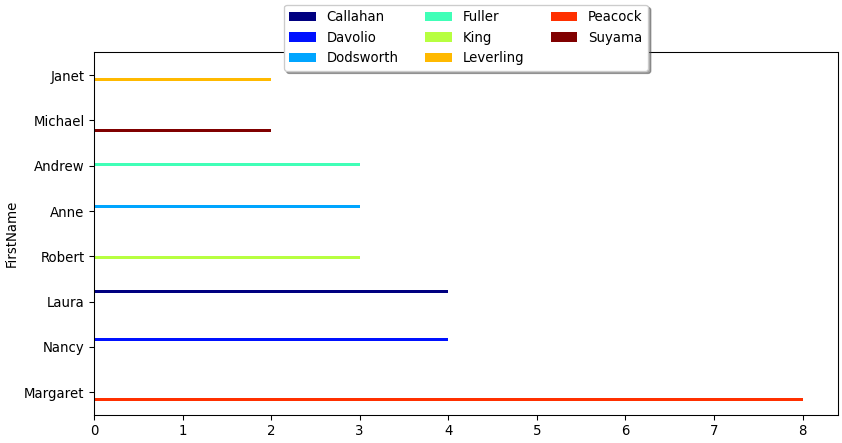

In [13]:
from pixiedust.display import *
display(result_df)

## <a id="lowlevel"></a> 5.2 Asynchronous Execution

In the subsequent cell the earlier created SQL statement is submitted. The method returns right away without waiting for the completion of the job execution. 

`submit_sql()` runs the given SQL string,  while `submit()` runs the internally via `sql_magic` module generated SQL string .

In [21]:
jobId = sqlClient.submit_sql(sql)
print("SQL query submitted and running in the background. jobId = " + jobId)

SQL query submitted and running in the background. jobId = ddecfffd-7b7c-4a88-83d1-b1bc767b3c37


In [22]:
print("Job status for " + jobId + ": " + sqlClient.get_job(jobId)['status'])

Job status for ddecfffd-7b7c-4a88-83d1-b1bc767b3c37: running


Use the `wait_for_job()` method as a blocking call until your job has finished:

In [23]:
job_status = sqlClient.wait_for_job(jobId)
print("Job " + jobId + " terminated with status: " + job_status)
if job_status == 'failed':
    details = sqlClient.get_job(jobId)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))

Job ddecfffd-7b7c-4a88-83d1-b1bc767b3c37 terminated with status: completed


Use the `get_result()` method to retrieve a dataframe for the SQL result set:

In [24]:
result_df = sqlClient.get_result(jobId)
print("OK, we have a dataframe for the SQL result that has been stored by SQL Query in " + sqlClient.get_job(jobId)['resultset_location'])

OK, we have a dataframe for the SQL result that has been stored by SQL Query in cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/myQueryResult/jobid=ddecfffd-7b7c-4a88-83d1-b1bc767b3c37


### Alternative method for asynchronous query submission using the internal statement created earlier using *sql_magic* :

In [28]:
print("Internal SQL query string created earlier using sql_magic:\n ")
sqlClient.print_sql()



Internal SQL query string created earlier using sql_magic:
 
SELECT o.OrderID,
       c.CompanyName,
       e.FirstName,
       e.LastName
FROM cos://us-geo/sql/orders.parquet STORED AS parquet o, cos://us-geo/sql/employees.parquet STORED AS parquet e, cos://us-geo/sql/customers.parquet STORED AS parquet c
WHERE e.EmployeeID = o.EmployeeID
  AND c.CustomerID = o.CustomerID
  AND o.ShippedDate > o.RequiredDate
  AND o.OrderDate > "1998-01-01"
ORDER BY c.CompanyName INTO cos://us-south/sqltempregional/myResult STORED AS CSV


In [29]:
jobId= sqlClient.submit()
print("\nSQL query submitted and running in the background. jobId = " + jobId)


SQL query submitted and running in the background. jobId = 2bff1a19-4ac4-4af7-ac55-3debfd7918f7


In [30]:
job_status = sqlClient.wait_for_job(jobId)
print("Job " + jobId + " terminated with status: " + job_status)
if job_status == 'failed':
    details = sqlClient.get_job(jobId)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))

Job 2bff1a19-4ac4-4af7-ac55-3debfd7918f7 terminated with status: completed


## <a id="execute_sql"></a> 5.3 Synchronous execution with optional result dataframe

The synchronuous execution of an SQL statement with run_sql() can cause Python runtime memory overload when the result set is big. Therefore a synchronous execution method is provided which allows to control whether the result set is to be returned as dataframe or only stored on cloud object storage.   

`execute_sql()` submits the sql statement, waits (until the query is completed), and returns a named tuple (data, job_id), with data being a dataframe optionally filled with the queried data. The option `get_result` controls if data are returned in the dataframe `data` or only stored on cloud object storage.  Setting get_result = "false"  is recommended if the result set is expected to be big. An alternative to deal with big result sets is to use pagination which is possible using the the `pagesize` option as described later.  

In [11]:
result = sqlClient.execute_sql(sql, get_result=True) 
display(result.data)

OrderID,CompanyName,FirstName,LastName
10924,Berglunds snabbköp,Janet,Leverling
11058,Blauer See Delikatessen,Anne,Dodsworth
10827,Bon app',Nancy,Davolio
11076,Bon app',Margaret,Peacock
11045,Bottom-Dollar Markets,Michael,Suyama
10970,Bólido Comidas preparadas,Anne,Dodsworth
11054,Cactus Comidas para llevar,Laura,Callahan
11008,Ernst Handel,Robert,King
11072,Ernst Handel,Margaret,Peacock
10816,Great Lakes Food Market,Margaret,Peacock


The equivalent method to run a SQL statement that was generated with *sql_magic* is `run()`.   

## <a id="paginated"></a>5.4 Use paginated SQL 

There is another alternative to deal with large result sets to avoid Python runtime memory overload when reading the result as a dataframe. You can return the result in small enough  "chunks" or "pages". All of the SQL execution methods previously introduced provide the optional paramemter `pagesize`. When set the result set is written in multiple objects with each having as many rows as specified in `pagesize`. Since this is implemented using the SQL Query syntax clause of `PARTITIONED EVERY <num> ROW` your query must not already contain another `PARTITIONED` clause when you set the `pagesize` parameter.
    
The following cells demonstrate the usage of the optional `pagesize` parameter.

In [32]:
pagination_sql='SELECT OrderID, c.CustomerID CustomerID, CompanyName, City, Region, PostalCode \
                FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o, \
                     cos://us-geo/sql/customers.parquet STORED AS PARQUET c \
                WHERE c.CustomerID = o.CustomerID \
                INTO {}paginated_orders STORED AS PARQUET'.format(targeturl)

formatted_etl_sql = sqlparse.format(pagination_sql, reindent=True, indent_tabs=True, keyword_case='upper')
result = highlight(formatted_etl_sql, lexer, formatter)
print('\nExample Statement is:\n')
print(result)

jobId = sqlClient.submit_sql(pagination_sql, pagesize=10)
job_status = sqlClient.wait_for_job(jobId)
print("Job " + jobId + " terminated with status: " + job_status)
job_details = sqlClient.get_job(jobId)
if job_status == 'failed':
    print("Error: {}\nError Message: {}".format(job_details['error'], job_details['error_message']))


Example Statement is:

SELECT OrderID,
	c.CustomerID CustomerID,
	CompanyName,
	City,
	Region,
	PostalCode
FROM cos://us-geo/SQL/orders.parquet STORED AS PARQUET o,
	cos://us-geo/SQL/customers.parquet STORED AS PARQUET c
WHERE c.CustomerID = o.CustomerID INTO cos://us-south/sqltempregional/paginated_orders STORED AS PARQUET

Job bcb736bc-0519-45a5-a52b-678066de20b2 terminated with status: completed


Let's check how many pages with each 10 rows have been written:

In [33]:
print("Number of pages written by job {}: {}".format(jobId, len(sqlClient.list_results(jobId))))

Number of pages written by job bcb736bc-0519-45a5-a52b-678066de20b2: 85


The following cell retrieves the first page of the result as a data frame. The desired page is specified as the optional parameter **`pagenumber`** to the `get_result()` method.

In [34]:
pagenumber=1
sqlClient.get_result(jobId, pagenumber=pagenumber).head(100)

,OrderID,CustomerID,CompanyName,City,Region,PostalCode
0,11011,ALFKI,Alfreds Futterkiste,Berlin,NULL,12209
1,10952,ALFKI,Alfreds Futterkiste,Berlin,NULL,12209
2,10835,ALFKI,Alfreds Futterkiste,Berlin,NULL,12209
3,10702,ALFKI,Alfreds Futterkiste,Berlin,NULL,12209
4,10692,ALFKI,Alfreds Futterkiste,Berlin,NULL,12209
5,10643,ALFKI,Alfreds Futterkiste,Berlin,NULL,12209
6,10926,ANATR,Ana Trujillo Emparedados y helados,México D.F.,NULL,05021
7,10759,ANATR,Ana Trujillo Emparedados y helados,México D.F.,NULL,05021
8,10625,ANATR,Ana Trujillo Emparedados y helados,México D.F.,NULL,05021
9,10308,ANATR,Ana Trujillo Emparedados y helados,México D.F.,NULL,05021


The following cell gets the next page. Run it multiple times in order to retrieve the subsequent pages, one page after the another.

In [35]:
pagenumber+=1
sqlClient.get_result(jobId, pagenumber).head(100)

,OrderID,CustomerID,CompanyName,City,Region,PostalCode
0,10856,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
1,10682,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
2,10677,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
3,10573,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
4,10535,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
5,10507,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
6,10365,ANTON,Antonio Moreno Taquería,México D.F.,NULL,05023
7,11016,AROUT,Around the Horn,London,NULL,WA1 1DP
8,10953,AROUT,Around the Horn,London,NULL,WA1 1DP
9,10920,AROUT,Around the Horn,London,NULL,WA1 1DP


## <a id="get_job"></a>5.5 get_job()

The method get_job() provides you with some execution related details. This way you can figure out the status of the job, the `result_location` on COS, the query start`start_time` and `end_time`, and the key performance metrics such as `bytes_read`.

In [36]:
job_details = sqlClient.get_job(jobId)
pprint.pprint(job_details)

{'bytes_read': 17111,
 'end_time': '2020-10-08T15:49:58.496Z',
 'job_id': 'bcb736bc-0519-45a5-a52b-678066de20b2',
 'plan_id': '72e394a3-9a56-432f-bc9d-8bc891f6adea',
 'resultset_format': 'parquet',
 'resultset_location': 'cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/paginated_orders/jobid=bcb736bc-0519-45a5-a52b-678066de20b2',
 'rows_read': 921,
 'rows_returned': 830,
 'statement': 'SELECT OrderID, c.CustomerID CustomerID, CompanyName, City, '
              'Region, PostalCode                 FROM '
              'cos://us-geo/sql/orders.parquet STORED AS PARQUET '
              'o,                      cos://us-geo/sql/customers.parquet '
              'STORED AS PARQUET c                 WHERE c.CustomerID = '
              'o.CustomerID                 INTO '
              'cos://us-south/sqltempregional/paginated_orders STORED AS '
              'PARQUET PARTITIONED EVERY 10 ROWS',
 'status': 'completed',
 'submit_time': '2020-10-08T15:49:01.620Z',
 'user_

# <a id="etl"></a> 6. Running ETL SQLs
[Home](#toc)

The following ETL SQL statement joins two data sets from COS and writes the result to COS using **hive style partitioning** with two columns. 

In [43]:
etl_sql='SELECT OrderID, c.CustomerID CustomerID, CompanyName, ContactName, ContactTitle, Address, City, Region, PostalCode, Country, Phone, Fax \
         EmployeeID, OrderDate, RequiredDate, ShippedDate, ShipVia, Freight, ShipName, ShipAddress, \
         ShipCity, ShipRegion, ShipPostalCode, ShipCountry FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o, \
         cos://us-geo/sql/customers.parquet STORED AS PARQUET c \
         WHERE c.CustomerID = o.CustomerID \
         INTO {}customer_orders STORED AS PARQUET PARTITIONED BY (ShipCountry, ShipCity)'.format(targeturl)
formatted_etl_sql = sqlparse.format(etl_sql, reindent=True, indent_tabs=True, keyword_case='upper')
result = highlight(formatted_etl_sql, lexer, formatter)
print('\nExample ETL Statement is:\n')
print(result)


Example ETL Statement is:

SELECT OrderID,
	c.CustomerID CustomerID,
	CompanyName,
	ContactName,
	ContactTitle,
	Address,
	City,
	Region,
	PostalCode,
	Country,
	Phone,
	Fax EmployeeID,
	OrderDate,
	RequiredDate,
	ShippedDate,
	ShipVia,
	Freight,
	ShipName,
	ShipAddress,
	ShipCity,
	ShipRegion,
	ShipPostalCode,
	ShipCountry
FROM cos://us-geo/SQL/orders.parquet STORED AS PARQUET o,
	cos://us-geo/SQL/customers.parquet STORED AS PARQUET c
WHERE c.CustomerID = o.CustomerID INTO cos://us-south/sqltempregional/customer_orders STORED AS PARQUET PARTITIONED BY (ShipCountry,
																																																																																																																									ShipCity)



In [44]:
jobId = sqlClient.submit_sql(etl_sql)
print("SQL query submitted and running in the background. jobId = " + jobId)
job_status = sqlClient.wait_for_job(jobId)
print("Job " + jobId + " terminated with status: " + job_status)
job_details = sqlClient.get_job(jobId)
if job_status == 'failed':
    print("Error: {}\nError Message: {}".format(job_details['error'], job_details['error_message']))

SQL query submitted and running in the background. jobId = 5cb281a9-96d0-42aa-ba74-f5e81e06ad70
Job 5cb281a9-96d0-42aa-ba74-f5e81e06ad70 terminated with status: completed


Now let's have a look at the cloud object storage location where the result objects are stored. The following cell uses the `get_cos_summary()` method to print a summary of the objects that have been written by the previous ETL SQL statement.

In [45]:
resultset_location = job_details['resultset_location']
sqlClient.get_cos_summary(resultset_location)

{'url': 'cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/',
 'total_objects': 71,
 'total_volume': '401.7 KB',
 'oldest_object_timestamp': 'October 08, 2020, 16H:08M:19S',
 'newest_object_timestamp': 'October 08, 2020, 16H:08M:31S',
 'smallest_object_size': '0.0 B',
 'smallest_object': 'customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/_SUCCESS',
 'largest_object_size': '7.1 KB',
 'largest_object': 'customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=UK/ShipCity=London/part-00015-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160820_0015_m_000015_65.c000.snappy.parquet'}

Note the **total_volume** value. We will reference it for comparison in the next steps. Also note the number in `total_objects`, which indicates that the ETL produced 69 partitions (71 objects minus two bookkeeping objects).

In the following cell we use the `list_results()` method to print a list of these 71 objects that have been written by the above ETL SQL statement. Note the partition columns and their values being part of the object names now. When you have a closer look at the cloud object storage URL of the objects you will notice that it contains the values of the partionting columns, e.g. `ShipCountry=Argentina/ShipCity=Buenos Aires` . All records in this result partition do have the value `Argentina` for column `ShipCountry`and `Buenos Aires` for `ChipCity`.  

The fact that the result data are partitioned this way and that this fact is made externally visible by making it part of the object name can be leveraged for example by a query engine to optimize the execution performance. This type of partitioning called **hive-style-partitioning**  is the basis for optimizing the execution of an SQL statement using predicates that match with the partitioning columns.

In [46]:
pd.set_option('display.max_colwidth', -1)
result_objects_df = sqlClient.list_results(jobId)
print("List of objects written by ETL SQL:")
result_objects_df.head(200)

List of objects written by ETL SQL:


,Object,LastModified,Size,StorageClass,Bucket,ObjectURL
0,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70,2020-10-08 16:08:15.376000+00:00,0,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70
1,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Argentina/ShipCity=Buenos Aires/part-00065-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160823_0015_m_000065_181.c000.snappy.parquet,2020-10-08 16:08:23.963000+00:00,6412,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Argentina/ShipCity=Buenos Aires/part-00065-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160823_0015_m_000065_181.c000.snappy.parquet
2,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Austria/ShipCity=Graz/part-00096-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160825_0015_m_000096_190.c000.snappy.parquet,2020-10-08 16:08:25.677000+00:00,6094,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Austria/ShipCity=Graz/part-00096-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160825_0015_m_000096_190.c000.snappy.parquet
3,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Austria/ShipCity=Salzburg/part-00015-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160820_0015_m_000015_65.c000.snappy.parquet,2020-10-08 16:08:20.204000+00:00,5636,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Austria/ShipCity=Salzburg/part-00015-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160820_0015_m_000015_65.c000.snappy.parquet
4,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Belgium/ShipCity=Bruxelles/part-00180-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160829_0015_m_000180_213.c000.snappy.parquet,2020-10-08 16:08:29.792000+00:00,5660,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Belgium/ShipCity=Bruxelles/part-00180-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160829_0015_m_000180_213.c000.snappy.parquet
5,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Belgium/ShipCity=Charleroi/part-00006-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160818_0015_m_000006_22.c000.snappy.parquet,2020-10-08 16:08:19.255000+00:00,5957,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Belgium/ShipCity=Charleroi/part-00006-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160818_0015_m_000006_22.c000.snappy.parquet
6,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Brazil/ShipCity=Campinas/part-00069-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160823_0015_m_000069_182.c000.snappy.parquet,2020-10-08 16:08:24.119000+00:00,5715,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Brazil/ShipCity=Campinas/part-00069-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160823_0015_m_000069_182.c000.snappy.parquet
7,customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/ShipCountry=Brazil/ShipCity=Resende/part-00042-fbedd840-b39b-46b1-9fcc-4ad51cc2e67a-attempt_20201008160821_0015_m_000042_135.c000.snappy.parquet,2020-10-08 16:08:22.082000+00:00,5749,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70/Ship

Now let's take a look at the result data with the `get_result()` method. Note that the result dataframe contains the two partitioning columns. The values for these have been put together by `get_result()` from the object names above because in hive style partitioning the partition column values are not stored in the objects but rather in the object names.

In [47]:
sqlClient.get_result(jobId).head(100)

,OrderID,CustomerID,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipRegion,ShipPostalCode,ShipCountry,ShipCity
0,10409,OCEAN,Océano Atlántico Ltda.,Yvonne Moncada,Sales Agent,Ing. Gustavo Moncada 8585 Piso 20-A,Buenos Aires,NULL,1010,Argentina,...,1997-02-06 06:00:00,1997-01-14 00:00:00.000,1,29.83,Océano Atlántico Ltda.,Ing. Gustavo Moncada 8585 Piso 20-A,NULL,1010,Argentina,Buenos Aires
1,10448,RANCH,Rancho grande,Sergio Gutiérrez,Sales Representative,Av. del Libertador 900,Buenos Aires,NULL,1010,Argentina,...,1997-03-17 06:00:00,1997-02-24 00:00:00.000,2,38.82,Rancho grande,Av. del Libertador 900,NULL,1010,Argentina,Buenos Aires
2,10521,CACTU,Cactus Comidas para llevar,Patricio Simpson,Sales Agent,Cerrito 333,Buenos Aires,NULL,1010,Argentina,...,1997-05-27 05:00:00,1997-05-02 00:00:00.000,2,17.22,Cactus Comidas para llevar,Cerrito 333,NULL,1010,Argentina,Buenos Aires
3,10531,OCEAN,Océano Atlántico Ltda.,Yvonne Moncada,Sales Agent,Ing. Gustavo Moncada 8585 Piso 20-A,Buenos Aires,NULL,1010,Argentina,...,1997-06-05 05:00:00,1997-05-19 00:00:00.000,1,8.12,Océano Atlántico Ltda.,Ing. Gustavo Moncada 8585 Piso 20-A,NULL,1010,Argentina,Buenos Aires
4,10716,RANCH,Rancho grande,Sergio Gutiérrez,Sales Representative,Av. del Libertador 900,Buenos Aires,NULL,1010,Argentina,...,1997-11-21 06:00:00,1997-10-27 00:00:00.000,2,22.57,Rancho grande,Av. del Libertador 900,NULL,1010,Argentina,Buenos Aires
5,10782,CACTU,Cactus Comidas para llevar,Patricio Simpson,Sales Agent,Cerrito 333,Buenos Aires,NULL,1010,Argentina,...,1998-01-14 06:00:00,1997-12-22 00:00:00.000,3,1.10,Cactus Comidas para llevar,Cerrito 333,NULL,1010,Argentina,Buenos Aires
6,10819,CACTU,Cactus Comidas para llevar,Patricio Simpson,Sales Agent,Cerrito 333,Buenos Aires,NULL,1010,Argentina,...,1998-02-04 06:00:00,1998-01-16 00:00:00.000,3,19.76,Cactus Comidas para llevar,Cerrito 333,NULL,1010,Argentina,Buenos Aires
7,10828,RANCH,Rancho grande,Sergio Gutiérrez,Sales Representative,Av. del Libertador 900,Buenos Aires,NULL,1010,Argentina,...,1998-01-27 06:00:00,1998-02-04 00:00:00.000,1,90.85,Rancho grande,Av. del Libertador 900,NULL,1010,Argentina,Buenos Aires
8,10881,CACTU,Cactus Comidas para llevar,Patricio Simpson,Sales Agent,Cerrito 333,Buenos Aires,NULL,1010,Argentina,...,1998-03-11 06:00:00,1998-02-18 00:00:00.000,1,2.84,Cactus Comidas para llevar,Cerrito 333,NULL,1010,Argentina,Buenos Aires
9,10898,OCEAN,Océano Atlántico Ltda.,Yvonne Moncada,Sales Agent,Ing. Gustavo Moncada 8585 Piso 20-A,Buenos Aires,NULL,1010,Argentina,...,1998-03-20 06:00:00,1998-03-06 00:00:00.000,2,1.27,Océano Atlántico Ltda.,Ing. Gustavo Moncada 8585 Piso 20-A,NULL,1010,Argentina,Buenos Aires


The following cell runs an SQL query against the **partitioned data** that has been produced by the previous ETL SQL statement. The query uses `WHERE` predicates on the columns the dataset is partitioned by. This allows for **performance optimization** during query execution. The query engine will physically only read the objects that match these predicate values exploiting the fact that the predicate columns match the partitioning columns. 

In [48]:
optimized_sql='SELECT * FROM {} STORED AS PARQUET WHERE ShipCountry = "Austria" AND ShipCity="Graz" \
               INTO {} STORED AS PARQUET'.format(resultset_location, targeturl)
formatted_optimized_sql = sqlparse.format(optimized_sql, reindent=True, indent_tabs=True, keyword_case='upper')
result = highlight(formatted_optimized_sql, lexer, formatter)
print('\nRunning SQL against the previously produced hive style partitioned objects as input:\n')
print(result)

jobId = sqlClient.submit_sql(optimized_sql)
job_status = sqlClient.wait_for_job(jobId)
print("Job " + jobId + " terminated with status: " + job_status)
job_details = sqlClient.get_job(jobId)
if job_status == 'failed':
    print("Error: {}\nError Message: {}".format(job_details['error'], job_details['error_message']))


Running SQL against the previously produced hive style partitioned objects as input:

SELECT *
FROM cos://s3.us-south.cloud-OBJECT-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70 STORED AS PARQUET
WHERE ShipCountry = "Austria"
		AND ShipCity="Graz" INTO cos://us-south/sqltempregional/ STORED AS PARQUET

Job 42eef19c-360c-47f4-9869-edc8fde840e0 terminated with status: completed


In the following cell we use `get_job()` to verify in the job details of the just run optimized SQL that hive style partitioning has been leveraged. Note the `bytes_read` value that is significantly lower than the `total_volume` value of the data in the queries data set. The number is 6408 bytes - remember that the total volume of input data is 408 KB. The number of `bytes_read` matches the size of the partion customer_orders/jobid=6ff7b1d0-b69c-4d1b-8ebf-968d69436f56/**ShipCountry=Argentina/ShipCity=Buenos Aires**/ . 
This reveals the fact that the execution engine leverages the hive style partitioning to optimze performance by only reading the partitions which match the filter predicate. This I/O avoidance is the reason for the increase of query performance and the lower the query cost.

In [50]:
sqlClient.get_job(jobId)

{'job_id': '42eef19c-360c-47f4-9869-edc8fde840e0',
 'status': 'completed',
 'statement': 'SELECT * FROM cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/customer_orders/jobid=5cb281a9-96d0-42aa-ba74-f5e81e06ad70 STORED AS PARQUET WHERE ShipCountry = "Austria" AND ShipCity="Graz"                INTO cos://us-south/sqltempregional/ STORED AS PARQUET',
 'plan_id': '72e394a3-9a56-432f-bc9d-8bc891f6adea',
 'submit_time': '2020-10-08T16:29:35.504Z',
 'resultset_location': 'cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=42eef19c-360c-47f4-9869-edc8fde840e0',
 'rows_returned': 30,
 'rows_read': 30,
 'bytes_read': 6090,
 'resultset_format': 'parquet',
 'end_time': '2020-10-08T16:29:47.064Z',
 'user_id': 'torsten@de.ibm.com'}

Partitioning data is also a worth a consideration when writing big result sets as this enables parallel writing and avoids memory problems. 

## <a id="analyze"></a> 6.1 Using analyze() for partitioning recommendation
[Home](#toc)

The `ibmcloudsql` SDK provides the `analyze()` on an existing job `job_id` and returns hints on how to partition data.
Below is an example in that we first query and store data in CSV format, before using the result in another query. Because of the data (from the first query) is not partitioned, the second query takes about 70 seconds. To understand how it can be improved, we call `analyze(job_id)`, which suggests that we can partition the data using either *PARTITIONED INTO* or *PARTITIONED EVERY* with the recommended value.

In [46]:
etl_sql='SELECT * FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO {cos_out_url} STORED AS CSV'.format(cos_out_url=targeturl)
result = sqlClient.execute_sql(etl_sql, get_result=False)
job_details = sqlClient.get_job(result.job_id)
 
import time
tic = time.perf_counter()
sql="""
SELECT COUNT(sid_sds011) as count_sids_sds011 
FROM (SELECT DISTINCT sensor_id as sid_sds011 FROM {cos_in_url} STORED AS CSV)""".format(cos_in_url=job_details['resultset_location'])
sqlClient.run_sql(sql)
toc = time.perf_counter()
print(f"Total time  in {toc - tic:0.4f} seconds")
print("==========")
sqlClient.analyze(result.job_id)

Total time  in 98.1436 seconds
Job 5732ae71-44cd-442f-b48c-8ec9b099932c has 1 object, with 1740.8 MB in total.
Best practices: object sizes ~ 128 MB
Current SQL:
 SELECT * FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO cos://us-south/sql-bf1d0641-06db-4c6a-8906-d42916b92288/result/ STORED AS CSV

Consider using: PARTITIONED INTO 13 OBJECTS/BUCKETS
Suggested SQL:
 SELECT *
FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO cos://us-south/sql-bf1d0641-06db-4c6a-8906-d42916b92288/result/ STORED AS PARQUET PARTITIONED INTO 13 OBJECTS

Consider using: PARTITIONED EVERY 2006029 ROWS
Suggested SQL:
 SELECT *
FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO cos://us-south/sql-bf1d0641-06db-4c6a-8906-d42916b92288/result/ STORED AS PARQUET PARTITIONED EVERY 2006029 ROWS



'Job 5732ae71-44cd-442f-b48c-8ec9b099932c has 1 object, with 1740.8 MB in total.\nBest practices: object sizes ~ 128 MB\nCurrent SQL:\n SELECT * FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO cos://us-south/sql-bf1d0641-06db-4c6a-8906-d42916b92288/result/ STORED AS CSV\n\nConsider using: PARTITIONED INTO 13 OBJECTS/BUCKETS\nSuggested SQL:\n SELECT *\nFROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO cos://us-south/sql-bf1d0641-06db-4c6a-8906-d42916b92288/result/ STORED AS PARQUET PARTITIONED INTO 13 OBJECTS\n\nConsider using: PARTITIONED EVERY 2006029 ROWS\nSuggested SQL:\n SELECT *\nFROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO cos://us-south/sql-bf1d0641-06db-4c6a-8906-d42916b92288/result/ STORED AS PARQUET PARTITIONED EVERY 2006029 ROWS\n'

In [45]:
# Here, we apply the suggestion above, by using `pagesize=2006029`

etl_sql='SELECT * FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/07/ STORED AS PARQUET INTO {cos_out_url} STORED AS CSV'.format(cos_out_url=targeturl)
result = sqlClient.execute_sql(etl_sql, get_result=False, pagesize=2006029)
job_details = sqlClient.get_job(result.job_id)

import time
tic = time.perf_counter()
sql="""
SELECT COUNT(sid_sds011) as count_sids_sds011 
FROM (SELECT DISTINCT sensor_id as sid_sds011 FROM {cos_in_url} STORED AS CSV)""".format(cos_in_url=job_details['resultset_location'])
sqlClient.run_sql(sql)
toc = time.perf_counter()
print(f"Total time  in {toc - tic:0.4f} seconds")

Total time  in 60.6923 seconds


# <a id="results"></a> 7. Work with result objects
[Home](#toc)

The result set, apart from being returned to the client as pandas.Dataframe, is also stored permanently on cloud object storage in the form of cloud object storage objects. There is a set of methods that allow you to work with the results on an object level.

## <a id="list_results"></a> 7.1 list_results() 

The result objects written to cloud object storage by default with a virtual sub folder structure in the following naming convention: 
    
        cos://endpoint/bucketname/resultSetName/jobid=<JOB_ID>/_SUCCESS 
        
        cos://endpoint/bucketname/resultSetName/jobid=<JOB_ID>
        
        cos://endpoint/bucketname/resultSetName/jobid=<JOB_ID>/part-<xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx>.<format>
    
where  `cos://endpoint/bucketname` is the target URL and resultSetName the user picked result set name as specified in the SQL INTO clause. The first two objects are of zero byte size and are merely used for bookkeepung purposes. The first `_SUCCESS` object indicates that all objects of the given data set have been successfully written. The second object is empty as well and denotes the name prefix of all objects belonging to a specific data set. You may think of it as the "root" in a naming hierachy for all result set related objects. The third object can in fact exist more than once if a `PARTIONED INTO` or `PARTITIONED EVERY` clause has been used. 

The following cell runs a simple SQL and lists the result objects for it. Since it uses a `PARTITIONED INTO 3 OBJECT` clause you can see three data objects being written.

In [8]:
pd.set_option('display.max_colwidth', -1)
sql="SELECT * FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET INTO {} STORED AS PARQUET PARTITIONED INTO 3 OBJECTS".format(targeturl)
jobId = sqlClient.submit_sql(sql)
sqlClient.wait_for_job(jobId)
sqlClient.list_results(jobId).head(100)

,Object,LastModified,Size,StorageClass,Bucket,ObjectURL
0,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c,2020-10-09 12:37:36.430000+00:00,0,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c
1,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/_SUCCESS,2020-10-09 12:37:44.714000+00:00,0,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/_SUCCESS
2,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00000-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123743_0004_m_000000_4.snappy.parquet,2020-10-09 12:37:43.832000+00:00,17499,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00000-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123743_0004_m_000000_4.snappy.parquet
3,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00001-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123743_0004_m_000001_5.snappy.parquet,2020-10-09 12:37:43.843000+00:00,17574,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00001-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123743_0004_m_000001_5.snappy.parquet
4,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00002-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123744_0004_m_000002_6.snappy.parquet,2020-10-09 12:37:44.211000+00:00,17854,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00002-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123744_0004_m_000002_6.snappy.parquet


## <a id="delete_result"></a> 7.2 delete_result()

You can delete the result set from Cloud Object Storage using the `delete_result()` method which deletes all cloud object storage objects related to the specified result set.

In [9]:
sqlClient.delete_result(jobId)



,Deleted Object
0,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/_SUCCESS
1,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00000-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123743_0004_m_000000_4.snappy.parquet
2,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c
3,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00002-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123744_0004_m_000002_6.snappy.parquet
4,jobid=4f6d78e9-3785-44e1-b886-3a59f8a1235c/part-00001-0964bb6d-8b3a-4487-9b47-74290adf2e2e-c000-attempt_20201009123743_0004_m_000001_5.snappy.parquet


## <a id="rename_result_objects"></a> 7.3 Enforce exact target object name

As described above an SQL job always writes a folder structure with three (or more when partitioned) objects to the cloud object store. The fact that the jobId is generated into the name of the objects ensures that in case the same SQL statement is executed multiple times the result set is not overwritten but stored in execution specific objects. If this is not desired, but the result is supposed to be overwritten each time the SQL statement is executed `JOBPREFIX NONE` clause can be used.  In the subsequent sample the optional clause `JOBPREFIX NONE` implies that the jobId is no longer part of the object name. 

But note, that this in turn implies each time the same target path - as specified in the INTO clause - will be used and therefore the result data set objects be "overwritten". The following sample demonstrates the effect of the `JOBPREFIX NONE` clause in an SQL statement on the naming of the result objects. Note, that the jobID is no longer part of the object names.  

In [10]:
sql="SELECT * FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET LIMIT 100 INTO {}first100orders.parquet JOBPREFIX NONE STORED AS PARQUET".format(targeturl)
jobId = sqlClient.submit_sql(sql)
sqlClient.wait_for_job(jobId)
sqlClient.list_results(jobId).head(100)

,Object,LastModified,Size,StorageClass,Bucket,ObjectURL
0,first100orders.parquet,2020-10-09 12:49:46.965000+00:00,0,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/first100orders.parquet
1,first100orders.parquet/_SUCCESS,2020-10-09 12:49:50.931000+00:00,0,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/first100orders.parquet/_SUCCESS
2,first100orders.parquet/part-00000-0d7c906e-e8e1-4bad-823f-36857d4cf8ef-c000-attempt_20201009124949_0005_m_000000_5.snappy.parquet,2020-10-09 12:49:50.386000+00:00,10271,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/first100orders.parquet/part-00000-0d7c906e-e8e1-4bad-823f-36857d4cf8ef-c000-attempt_20201009124949_0005_m_000000_5.snappy.parquet


With this your result object name is closer your actually specified path in the `INTO` clause, but it is still not EXACTLY the same. When you write a single partitioned result there is only one object with the data and you may want to have a single result object without any virtual folder structure. For this case you can use the method `rename_exact_result()` on a jobId for a job that has a single partitoned result.

In [11]:
sqlClient.rename_exact_result(jobId)
sqlClient.list_results(jobId).head(100)

,Object,LastModified,Size,StorageClass,Bucket,ObjectURL
0,first100orders.parquet,2020-10-09 12:53:02.890000+00:00,10271,STANDARD,sqltempregional,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/first100orders.parquet


After applying this method to the jobs' result the `list_results()` method shows exactly one object - the one containing the result data - with the result set name as specified in the `INTO` clause.

# <a id="catalog"></a>8 Work with hive tables
[Home](#toc)

So far all SQL statements used cloud object storage URLs to specify the input data of an SQL statement. This can be cumbersome. With ibmcloudsql version 0.4 SQL Query introduced hive meta store support. This enables the usage of table names in SQL statements rather than cloud object storage URLs. The hive meta store is a catalog  which holds for each table all related metadata including the table name, the schema, the backing cloud object storage objects, partitioning information etc.

NOTE: Using this requires Standard Plan for SQL Query.

One can create tables, list tables, drop tables etc. The APIs for catalog management can be found <a href="https://ibm-cloud.github.io/sql-query-clients/sql_query.html#f-manage-table-catalog"> here </a>.    

Let's  first create table for a simple sample dataset customers.csv provided by SQL Query. The `create_table()` method creates an object in the hive metastore containing the table name and the schema of the table. When not specifying the optional paramter `schema` the schema is automatically discovered from the data on COS.

In [12]:
sqlClient.create_table("customers", cos_url="cos://us-geo/sql/customers.csv", format_type="csv", force_recreate=True)

With `describe_table()` you can retrieve the schema information in the catalog. 

In [14]:
customers_schema = sqlClient.describe_table("customers")
customers_schema.head(100)

,col_name,data_type,comment
0,customerID,string,NaN
1,companyName,string,NaN
2,contactName,string,NaN
3,contactTitle,string,NaN
4,address,string,NaN
5,city,string,NaN
6,region,string,NaN
7,postalCode,string,NaN
8,country,string,NaN
9,phone,string,NaN


In the following cell we run the `create_table()` again but this time we specify the schema explicitly:

In [15]:
sqlClient.create_table("customers", cos_url="cos://us-geo/sql/customers.csv", format_type="csv", force_recreate=True,
                       schema="(customerID string, companyName string, contactName string, contact_Title string, address string, city string)")

When you have hive-partitioned dataset on COS (i.e. the sub folder hierarchy adhere to the hive naming convention) you can create a partitioned table using the `create_partitioned_table()` method. 

In [16]:
sqlClient.create_partitioned_table("customers_partitioned", cos_url="cos://us-geo/sql/customers_partitioned.csv", format_type="csv", force_recreate=True)
customers_partitioned_schema = sqlClient.describe_table("customers_partitioned")
customers_partitioned_schema.head(100)

,col_name,data_type,comment
0,customerID,string,NaN
1,companyName,string,NaN
2,contactName,string,NaN
3,contactTitle,string,NaN
4,address,string,NaN
5,city,string,NaN
6,region,string,NaN
7,postalCode,string,NaN
8,phone,string,NaN
9,fax,string,NaN


Note: After creatung a partitioned table it is always initially emply until you have added the partitions to it. A convenient method to do this is via the `recover_table_partitions()` method.

In [17]:
sqlClient.recover_table_partitions("customers_partitioned")

You can get a list of created tables with `show_tables()`.

In [18]:
 sqlClient.show_tables()

,tableName
0,counties
1,customer_statistics
2,customers
3,customers_partitioned
4,eu_demographic
5,geographic
6,geographic_full
7,jdbc_test_table
8,position_data
9,position_data2


Alternatively to the above convenience methods for managing hive tables you can use [DDL statements](https://cloud.ibm.com/docs/sql-query?topic=sql-query-sql-reference#chapterHiveCatalog) and run them via `submit_sql()`. This gives you the full set of hive table management commands and options, which goes beyond what the above convenience methods cover.

## <a id="manage_jobs"></a> 9. Manage SQL jobs 

[Home](#toc)

### <a id='joblist'></a> 9.1. Work with Job History

The set of APIs that allow you to interact with jobs is provided via <a href="https://ibm-cloud.github.io/sql-query-clients/sql_query.html#d-manage-jobs">this link</a>. 

Many of them are useful when you are launching **many** SQL statements e.g.

1. get the list of running jobs: `get_jobs_with_status()`
2. get the list of jobs that have been launched in the given session: `myjobs()`
3. get up-to-30 most recent jobs: `get_jobs()`
4. export the list of jobs: `export_job_history()`

The next cell lists the most recent 30 jobs in your instance of SQL Query:

In [26]:
pd.set_option('display.max_colwidth', -1) 
#You can change the value -1 for display.max_colwidth to a positive integer if you want to truncate the cell content to shrink the overall table display size.

job_history_df = sqlClient.get_jobs()
job_history_df.head(100)

,job_id,status,user_id,statement,resultset_location,submit_time,end_time,rows_read,rows_returned,bytes_read,objects_skipped,objects_qualified,error,error_message
0,227871dd-b957-451d-935d-e0f16cd5e8f6,completed,torsten@de.ibm.com,"SELECT o.OrderID, c.CompanyName, e.FirstName, e.LastName FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o, cos://us-geo/sql/employees.parquet STORED AS PARQUET e, cos://us-geo/sql/customers.parquet STORED AS PARQUET c WHERE e.EmployeeID = o.EmployeeID AND c.CustomerID = o.CustomerID AND o.ShippedDate > o.RequiredDate AND o.OrderDate > ""1998-01-01"" ORDER BY c.CompanyName INTO cos://us-south/sqltempregional/myQueryResult STORED AS CSV",cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/myQueryResult/jobid=227871dd-b957-451d-935d-e0f16cd5e8f6,2020-10-09T13:24:31.142Z,2020-10-09T13:24:39.730Z,1760,29,41499,None,None,,
1,b7fbae1b-72f3-411d-a2f2-4ed910c870bc,completed,torsten@de.ibm.com,SELECT * FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET LIMIT 100 INTO cos://us-south/sqltempregional/first100orders.parquet JOBPREFIX NONE STORED AS PARQUET,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/first100orders.parquet,2020-10-09T13:19:41.747Z,2020-10-09T13:19:53.532Z,830,100,30606,None,None,,
2,d65998eb-e087-4ef6-b08c-d6aee584ff19,completed,torsten@de.ibm.com,\n SHOW TABLES\n INTO cos://us-south/sqltempregional/ STORED AS CSV\n,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=d65998eb-e087-4ef6-b08c-d6aee584ff19,2020-10-09T13:15:01.666Z,2020-10-09T13:15:05.849Z,None,14,None,None,None,,
3,90080c71-adf2-4661-9fd5-ed5790e91924,completed,torsten@de.ibm.com,ALTER TABLE customers_partitioned RECOVER PARTITIONS\n,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=90080c71-adf2-4661-9fd5-ed5790e91924,2020-10-09T13:13:49.510Z,2020-10-09T13:14:04.242Z,None,None,None,None,None,,
4,9776f918-8453-418b-a8be-3273e9d964e9,completed,torsten@de.ibm.com,\n DESCRIBE TABLE customers_partitioned INTO cos://us-south/sqltempregional/ STORED AS CSV,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=9776f918-8453-418b-a8be-3273e9d964e9,2020-10-09T13:12:06.191Z,2020-10-09T13:12:15.249Z,None,14,None,None,None,,
5,b9c45ef5-f7ac-460d-b728-89cee0186a5d,completed,torsten@de.ibm.com,ALTER TABLE customers_partitioned RECOVER PARTITIONS\n,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=b9c45ef5-f7ac-460d-b728-89cee0186a5d,2020-10-09T13:11:45.332Z,2020-10-09T13:12:04.232Z,None,None,None,None,None,,
6,48881240-c1f5-4c4c-ae35-73179456e035,completed,torsten@de.ibm.com,\n CREATE TABLE customers_partitioned\n USING csv\n LOCATION cos://us-geo/sql/customers_partitioned.csv\n,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=48881240-c1f5-4c4c-ae35-73179456e035,2020-10-09T13:11:25.168Z,2020-10-09T13:11:40.974Z,None,None,None,None,None,,
7,d865c9d3-349e-484d-99f7-a6a135330409,completed,torsten@de.ibm.com,\n DROP TABLE customers_partitioned,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=d865c9d3-349e-484d-99f7-a6a135330409,2020-10-09T13:11:11.625Z,2020-10-09T13:11:23.294Z,None,None,None,None,None,,
8,1942f5ec-e195-439a-86d9-5cdd21c6041d,completed,torsten@de.ibm.com,\n SHOW TABLES\n INTO cos://us-south/sqltempregional/ STORED AS CSV\n,cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=1942f5ec-e195-439a-86d9-5cdd21c6041d,2020-10-09T13:11:03.790Z,2020-10-09T13:11:08.790Z,None,14,None,None,None,,
9,96f22e36-2444-4b7d-b2e1-f5ed4634de4d,completed,torsten@de.ibm.com,"\n CREATE TABLE customers (customerID string, companyName string, contactName string, contact_Title string, address string, city string)\n USING csv\n LOCATION cos://us-geo/sql/customers.csv\n",cos://s3.us-south.cloud-object-storage.appdomain.cloud/sqltempregional/jobid=96f22e36-2444-4b7d-b2e1-f5ed4634de4d,2020-10-09T13:09:14.133Z,2020-10-09T13:09:19.8

If you need a longer history of your jobs then you need to periodically export the current job history to a location on COS. This can be achieved conveniently with the method `export_job_history()`

In [27]:
sqlClient.export_job_history(targeturl + "my_job_history/",   "job_export_" , ".parquet")  
# sqlClient.export_job_history(targeturl + "my_job_history/" , "job_export_" , ".parquet")  

Exported 30 new jobs


Each time when you run this function it performs a delta check of the currently available recent history of 30 jobs with the already stored jobs on the specified location and writes out an additional parquet partition with only the new jobs that hadn't been exported previously:

In [28]:
# Run another SQL:
sql="SELECT * FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET LIMIT 100 INTO {} STORED AS PARQUET".format(targeturl)
jobId = sqlClient.submit_sql(sql)
sqlClient.wait_for_job(jobId)

#Export job history again:
sqlClient.export_job_history(targeturl + "my_job_history/",   "job_export_" , ".parquet")

# Query exported job history:
pd.set_option('display.max_colwidth', 20)
sql = "SELECT * FROM {}my_job_history/ STORED AS PARQUET INTO {} STORED AS PARQUET".format(targeturl, targeturl)
sqlClient.run_sql(sql)

Exported 1 new jobs


,job_id,status,user_id,statement,resultset_location,submit_time,end_time,rows_read,rows_returned,bytes_read,objects_skipped,objects_qualified,error,error_message
0,227871dd-b957-45...,completed,torsten@de.ibm.com,SELECT o.OrderID...,cos://s3.us-sout...,2020-10-09T13:24...,2020-10-09T13:24...,1760.0,29.0,41499.0,NaN,NaN,,
1,b7fbae1b-72f3-41...,completed,torsten@de.ibm.com,SELECT * FROM co...,cos://s3.us-sout...,2020-10-09T13:19...,2020-10-09T13:19...,830.0,100.0,30606.0,NaN,NaN,,
2,d65998eb-e087-4e...,completed,torsten@de.ibm.com,\n SHOW T...,cos://s3.us-sout...,2020-10-09T13:15...,2020-10-09T13:15...,NaN,14.0,NaN,NaN,NaN,,
3,90080c71-adf2-46...,completed,torsten@de.ibm.com,ALTER TABLE cust...,cos://s3.us-sout...,2020-10-09T13:13...,2020-10-09T13:14...,NaN,NaN,NaN,NaN,NaN,,
4,9776f918-8453-41...,completed,torsten@de.ibm.com,\n DESCRI...,cos://s3.us-sout...,2020-10-09T13:12...,2020-10-09T13:12...,NaN,14.0,NaN,NaN,NaN,,
5,b9c45ef5-f7ac-46...,completed,torsten@de.ibm.com,ALTER TABLE cust...,cos://s3.us-sout...,2020-10-09T13:11...,2020-10-09T13:12...,NaN,NaN,NaN,NaN,NaN,,
6,48881240-c1f5-4c...,completed,torsten@de.ibm.com,\n ...,cos://s3.us-sout...,2020-10-09T13:11...,2020-10-09T13:11...,NaN,NaN,NaN,NaN,NaN,,
7,d865c9d3-349e-48...,completed,torsten@de.ibm.com,\n DROP T...,cos://s3.us-sout...,2020-10-09T13:11...,2020-10-09T13:11...,NaN,NaN,NaN,NaN,NaN,,
8,1942f5ec-e195-43...,completed,torsten@de.ibm.com,\n SHOW T...,cos://s3.us-sout...,2020-10-09T13:11...,2020-10-09T13:11...,NaN,14.0,NaN,NaN,NaN,,
9,96f22e36-2444-4b...,completed,torsten@de.ibm.com,\n ...,cos://s3.us-sout...,2020-10-09T13:09...,2020-10-09T13:09...,NaN,NaN,NaN,NaN,NaN,,


## <a id="many_queries"></a> 9.2. Batch automation of SQL jobs
[Home](#toc)


Assume you want to automate your ETL process and there is a situation where you have to submit many SQL statements at once. Doing so you have to be aware of the fact that there is a limit to the number of queries that can be served by a single SQL Query instance at a time. This is 1 for Lite Plan; and 5 for Standard Plan. If some of your jobs are long running it may happen that some jobs are not yet  completed when the session ends.  

Since `ibmcloudsql` 0.4, if you're using Watson Studio,there is also the possibility to retry jobs which did not complete within the session they have been started in. At a later point in time when you start a new session you may want to  restart those jobs which did not complete. You do so by connecting to the [Project-Lib](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html), and save the list of jobs submitted in a file in the project bucket. When you re-run the session, the status of the execution of all jobs is updated and the jobs which did not complete in the previous session are  re-executed. 

The following code in the following cell demonstrates this behaviour. Re-run the cell a couple of times and check the file "tracked_jobs_new.json" in the project bucket to observe the behavior.  

This can be used in Watson Studio with ProjectLib activated using a file stored as an asset in the project, or it can also be used using a file from a local machine.

REF: The API docs is provided via <a href="https://ibm-cloud.github.io/sql-query-clients/ibmcloudsql.html#ibmcloudsql.SQLQuery.SQLQuery.submit_and_track_sql">this link</a>. 



In [63]:
 
file_name="tracked_jobs1.json"
sqlClient.connect_project_lib(project, file_name)

sql_stmt1='SELECT o.OrderID  FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o LIMIT 5 ' 
sql_stmt2='SELECT o.OrderID  FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o LIMIT 10 ' 
sql_stmt3='SELECT o.OrderID  FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o LIMIT 15 '
sql_stmt4='SELECT o.OrderID  FROM cos://us-geo/sql/orders.parquet STORED AS PARQUET o LIMIT 20'
 

jobs = [ ]

jobs.append(sqlClient.submit_and_track_sql(sql_stmt1))
jobs.append(sqlClient.submit_and_track_sql(sql_stmt2))
jobs.append(sqlClient.submit_and_track_sql(sql_stmt3))  
jobs.append(sqlClient.submit_and_track_sql(sql_stmt4))

Job d9e0ccb7-e0a9-49f2-b80e-452196841f63 completed
Job 398b2d9a-6dfd-4072-b2bd-5dbeb007a9ff completed
Job d6f4c70a-6451-4f22-bfd2-224f6713bb9d completed
Job c73d0fb7-2f54-4ea4-b8d0-7dece7a1cf2d completed


Here, if you are given a list of job_id, you can run them all, and each will be checked with those saved in the `file_name` stored in ProjectLib. 

In [64]:
sqlClient.process_failed_jobs_until_all_completed(jobs)


['d9e0ccb7-e0a9-49f2-b80e-452196841f63',
 '398b2d9a-6dfd-4072-b2bd-5dbeb007a9ff',
 'd6f4c70a-6451-4f22-bfd2-224f6713bb9d',
 'c73d0fb7-2f54-4ea4-b8d0-7dece7a1cf2d']

# <a id="next"></a> 10. Next steps

[Home](#toc)

In this notebook you learned how you can use the `ibmcloudsql` library in a Python notebook to submit SQL queries on data in IBM Cloud Object Storage and how you can interact with the query results. If you want to automate such an SQL query execution as part of your cloud solution, apart from the solution using ProjectLib, you can use the <a href="https://console.bluemix.net/openwhisk/" target="_blank">IBM Cloud Functions</a> framework. There is a dedicated SQL function available that lets you set up a cloud function to run SQL statements with IBM Cloud SQL Query. You can find the documentation for doing this <a href="https://hub.docker.com/r/ibmfunctions/sqlquery/" target="_blank" rel="noopener noreferrer">here</a>.

### <a id="authors"></a>Authors

**Torsten Steinbach**, Torsten is the lead architect for IBM Cloud Data Lake. Previously he has worked as IBM architect for a series of data management products and services, including DB2, PureData for Analytics and Db2 on Cloud.

**Tuan M. HoangTrong**, Tuan is the research staff member in the Distributed AI, TimeSeries Group. 

<hr>
Copyright &copy; IBM Corp. 2020. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>